# Stacked Autoencoders and Classification
Although autoencoders are an unsupervised algorithm, it turns out that they can play a very important role in supervised alorithms.

The basic idea is this: let's say you have a relatively small dataset of images that you would like to train a classifier on.   Since the dataset is small, you would expect that the performance of the trained classifier on new unseen data will not be so great.   However, you know of a much larger dataset of similar images, but that dataset is unlabeled.   Can this unlabeled dataset help?

The answer is yes - and the idea depends on autoencoders.   You train an autoencoder (built as we have using a separate encoder and decoder) on the unlabeled data.  Then you use the encoder - which has learned features from the unlabeled data, and put this in place of your input layers of your standard CNN.  You put a fully connected layer after this, followed by a softmax layer and you then train that combination.   Note that the encoder weights are **not** modified during this procedure!  However the weights of the fully connected layers after the encoder are modified during training.

Let's see how this works.   First, we will train a standard CNN, but we will build it with an eye towards replacing the input layer later on with our already trained enocder.

## Load the data

In [3]:
from keras.datasets import mnist
import numpy as np
import scipy.io as sio
#
# See this for more info: https://arxiv.org/pdf/1702.05373.pdf
mat = sio.loadmat('/fs/scratch/PAS1495/physics6820/emnist/matlab/emnist-byclass.mat')
#print(mat)

data = mat['dataset']

ex_train = data['train'][0,0]['images'][0,0]
ey_train = data['train'][0,0]['labels'][0,0]
ex_test = data['test'][0,0]['images'][0,0]
ey_test = data['test'][0,0]['labels'][0,0]

ex_train = ex_train.reshape( (ex_train.shape[0], 28,28), order='F')
ex_test = ex_test.reshape( (ex_test.shape[0], 28,28), order='F')

ex_train = ex_train.reshape( (ex_train.shape[0], 784))
ex_test = ex_test.reshape( (ex_test.shape[0], 784))
ex_train = ex_train.astype('float32') / 255.
ex_test = ex_test.astype('float32') / 255.

import pandas as pd

df_train = pd.DataFrame(ex_train)
df_train['label'] = ey_train
df_digits_train = df_train[df_train['label']<=9]
#print(df_digits_train)
x_train = df_digits_train.iloc[:,:784].values
x_train = x_train.reshape((x_train.shape[0],28,28,1))
y_train = df_digits_train['label'].values
print(x_train.shape,y_train.shape)

df_test = pd.DataFrame(ex_test)
df_test['label'] = ey_test
df_digits_test = df_test[df_test['label']<=9]
#print(df_digits_test)
x_test = df_digits_test.iloc[:,:784].values
x_test = x_test.reshape((x_test.shape[0],28,28,1))
y_test = df_digits_test['label'].values
print(x_test.shape,y_test.shape)

#
from keras.utils import to_categorical

y_train_labels_cat = to_categorical(y_train)
y_test_labels_cat = to_categorical(y_test)



(345035, 28, 28, 1) (345035,)
(57918, 28, 28, 1) (57918,)


## Build a standard CNN
In building the standard network below, we make sure to separate the CNN portion of the network - which we call **cnn_prenetwork** below - from the flattened and fully connected portion of the network.   There is no real difference between this network and the one we designed a couple of weeks ago.

In [4]:
from keras import models
from keras import layers
#
# Define the initial part of the CNN as a "pre" network
cnn_prenetwork = models.Sequential()
cnn_prenetwork.add(layers.Conv2D(30,(5,5),activation='relu',input_shape=(28,28,1)))
cnn_prenetwork.add(layers.MaxPooling2D((2,2)))
cnn_prenetwork.add(layers.Conv2D(25,(5,5),activation='relu'))
cnn_prenetwork.add(layers.MaxPooling2D((2,2)))
print(cnn_prenetwork.summary())
#
# Now make our actual full network - using the above "pre" network as our first layer
cnn_network = models.Sequential()
#
# Connect to a dense output layer - just like an FCN
cnn_network.add(cnn_prenetwork)
cnn_network.add(layers.Flatten())
cnn_network.add(layers.Dense(64,activation='relu'))
cnn_network.add(layers.Dense(10,activation='softmax'))
#
# Compile
cnn_network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
#
# Fit/save/print summary
history = cnn_network.fit(x_train,y_train_labels_cat,epochs=5,batch_size=256,
                              validation_data=(x_test,y_test_labels_cat))
cnn_network.save('fully_trained_model_cnn.h5')
print(cnn_network.summary())
print("Validation accuracy" ,history.history['val_acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 25)          18775     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 25)          0         
Total params: 19,555
Trainable params: 19,555
Non-trainable params: 0
_________________________________________________________________
None
Train on 345035 samples, validate on 57918 samples
Epoch 1/5
345035/345035 [==============================] - 238s 688us/step - loss: 0.0958 - acc: 0.9713 - val_loss: 0.0324 - val_acc: 0.9905
Epoch 2/5
345035/345035 [==============================] - 231s 669us/ste

## Plot performance vs epoch
From the plot below it is clear that the fit has not yet converged - but we limited the epochs to save time.

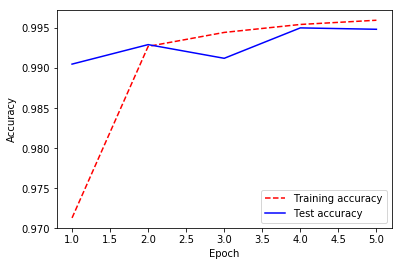

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get training and test loss histories
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## Now build a stacked autoencoder CNN
The only change we will make with this network is to replace **cnn_prenetwork** with the encoder network that we already trained.   We will use the one trained on the larger digit sample, and stored on disk, called **fully_trained_encoder_cnn.h5**.

Remember that the encoder we use here was trained as part of an autoencoder.  The goal in that case was to discover features that would help reconstruct the original image.  The autoencoder knew **nothing** about the labels of the digits it was training on!

In [7]:
from keras import models
from keras import layers
from keras.models import load_model
#
#encoder = load_model('fully_trained_encoder_cnn.h5')
encoder = load_model('fully_trained_encoder_cnn.h5')
#
for layer in encoder.layers:
    layer.trainable = False
    print(layer, layer.trainable)
    
cnn_network = models.Sequential()
#
# Connect to a dense output layer - just like an FCN
cnn_network.add(encoder)
cnn_network.add(layers.Flatten())
cnn_network.add(layers.Dense(64,activation='relu'))
cnn_network.add(layers.Dense(10,activation='softmax'))
#
# Compile
cnn_network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
#
# Fit/save/print summary
history = cnn_network.fit(x_train,y_train_labels_cat,epochs=5,batch_size=256,
                              validation_data=(x_test,y_test_labels_cat))
cnn_network.save('fully_trained_model_cnn_stacked_ae.h5')
print(cnn_network.summary())


/users/PAS1495/gsdbuilder/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<keras.layers.convolutional.Conv2D object at 0x2babde6905f8> False
<keras.layers.pooling.MaxPooling2D object at 0x2babde690ac8> False
<keras.layers.convolutional.Conv2D object at 0x2babde6907b8> False
<keras.layers.pooling.MaxPooling2D object at 0x2babde6e28d0> False
<keras.layers.convolutional.Conv2D object at 0x2babde6e2f28> False
<keras.layers.pooling.MaxPooling2D object at 0x2babde6f7b70> False
Train on 345035 samples, validate on 57918 samples
Epoch 1/5
345035/345035 [==============================] - 44s 127us/step - loss: 0.3197 - acc: 0.9126 - val_loss: 0.1795 - val_acc: 0.9461
Epoch 2/5
345035/345035 [==============================] - 43s 125us/step - loss: 0.1391 - acc: 0.9579 - val_loss: 0.1210 - val_acc: 0.9633
Epoch 3/5
345035/345035 [==============================] - 47s 136us/step - loss: 0.1144 - acc: 0.9653 - val_loss: 0.1051 - val_acc: 0.9688
Epoch 4/5
345035/345035 [==============================] - 47s 136us/step - loss: 0.1007 - acc: 0.9694 - val_loss: 0.1022 - val

In [8]:
print(history.history)

{'val_loss': [0.17947058416235376, 0.12101719184915986, 0.10509127270740477, 0.10217916237484244, 0.08551952518372745], 'val_acc': [0.9460789391919474, 0.9633274629340077, 0.9687834524837473, 0.9687834524364077, 0.9744466314135823], 'loss': [0.31969349089575516, 0.13910852766662168, 0.11439429104787237, 0.10074308959926125, 0.09213375156920736], 'acc': [0.9126204587966267, 0.9579086179716485, 0.9652556986863504, 0.9693509354014662, 0.9719709594785906]}


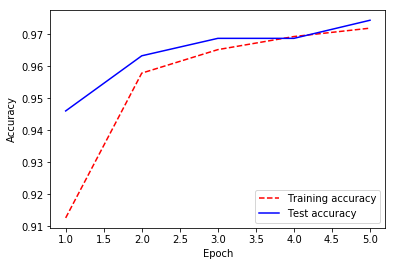

In [9]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

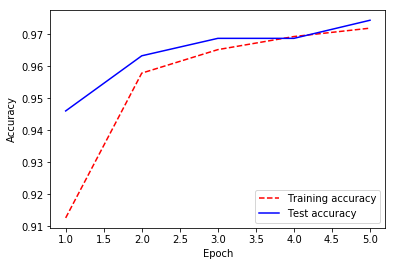

In [10]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## Summary
We see that the performance of the stacked autoencoder/classifier is comparable to that of a fully trained CNN classifier.   Again: the encoder we used knew nothing about the labels of our data - it simply learned features useful for encoding/decoding.   But these learned features turned out to be very useful for classification!